---
# <div style="text-align: center;"> Assignment 2 </div>

<div style="text-align: center;">
Name: Jiahui Bai (3735049)
</div>

<div style="text-align: center;">
Name: Dewei Ning (3962963)
</div>

---

Import the necessary dependent libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import math
import random
import matplotlib.image as mpimg
from PIL import Image
import cv2
from scipy.stats import ks_2samp

Get the dataset as a dataframe

In [2]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

# EDA
## Dataset foundation information
这是一个包含9896个条目的数据集，每个条目都有6个字段。这些字段包括`InstanceID`（实例ID）、`patientID`（患者ID）、`ImageName`（图像名称）、`cellTypeName`（细胞类型名称）、`cellType`（细胞类型）、`isCancerous`（是否为癌症细胞）。这些字段中，四个是整数类型(int64)，两个是对象类型(object)，表示它们是字符串或者其他非数值类型的数据。

从数据类型来看，我们可以知道这个数据集主要包含了以下信息：

1. **InstanceID**：这是每个条目的唯一标识符，通常用于唯一标记每一个样本。
2. **patientID**：这是每个病人的唯一标识符。
3. **ImageName**：这是每个细胞图像的文件名或路径。
4. **cellTypeName**：这是细胞类型的名字。
5. **cellType**：这是细胞类型的数值编码。
6. **isCancerous**：这是一个布尔值，表示细胞是否为癌症细胞。

数据集中的所有字段都没有缺失值，这意味着我们可以直接使用这个数据集进行后续的数据分析和模型训练，无需进行缺失值的处理。

数据信息和任务要求，目标是使用给定的数据集的图像分类为癌症和细胞类别。因此，这是一个监督学习问题，此任务是一个二分类任务和一个多分类任务。

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


## Check image details
从下面结果我们可以发现，数据集中有 9896 个细胞图像。图像大小为 27*27，由于图像尺寸的标准偏差为 0，因此数据集中的所有图像均为 27*27，这意味着它们具有相同的尺寸。这对于我们进行图像分类任务来说非常有利，因为这消除了需要对图像进行尺寸标准化的步骤。具有相同尺寸的图像可以直接输入到神经网络模型中，无需进行额外的预处理步骤，这不仅大大节省了预处理时间，也减少了可能引入的误差。此外，相同的图像尺寸也可以确保我们的模型在整个数据集上保持一致的表现，提高模型的稳定性和可靠性。

In [4]:
# calculate the length of the dataset.
dataset_size = len(data)
# Save the all the image's file names into 'image_files'
image_files = data['ImageName'].values
# Calculate all the types of cells
num_classes = data['cellTypeName'].nunique()
#Calculate all the patients number
num_patients = data['patientID'].nunique()
# Get the size of the images
image_sizes = []
for image_file in image_files:
    image = Image.open("./Image_classification_data/patch_images/" + image_file)
    image_sizes.append(image.size)
# Calculate the mean and standard deviation of the image size
mean_image_size = np.mean(image_sizes, axis=0)
std_image_size = np.std(image_sizes, axis=0)
# Print output
print(f"Dataset Size: {dataset_size}")
print(f"Number of Categories: {num_classes}")
print(f"Number of Patients: {num_patients}")
print(f"Image Size Mean: {mean_image_size}")
print(f"Image Size Standard Deviation: {std_image_size}")

Dataset Size: 9896
Number of Categories: 4
Number of Patients: 60
Image Size Mean: [27. 27.]
Image Size Standard Deviation: [0. 0.]


## Duplicate Sample Detection
我们通过下面的代码检测数据集中是否存在重复的图像，即一个图像对应多个患者。这对我们分析数据以及构建和训练模型可能会有一定的影响，因为我们通常希望数据中的每个图像都对应一个独特的患者，以避免数据混淆或错误。如果存在这种重复的图像，我们可能需要进一步调查并确定如何处理这些数据。

In [5]:
# Calculate how many patients does the image belong to.
grouped = data.groupby(['ImageName', 'patientID']).size().reset_index(name='counts')

# Find 'ImageName' with 'counts' larger than 1
duplicated_images = grouped[grouped.duplicated('ImageName', keep=False)]['ImageName'].unique()

# print output
if len(duplicated_images) > 0:
    print("Here is the image which has different patients with it：")
    for image in duplicated_images:
        print(image)
else:
    print("There is no image corresponding to multiple patients.")

There is no image corresponding to multiple patients.


## 每位患者的各类细胞计数分布
我们利用下面的代码，展示了每位患者（`patientID`）的不同类型细胞（`cellTypeName`）的计数。通过观察这个图，我们可以看到，每位患者的细胞类型分布并不相同，某些类型的细胞在某些患者中更常见，而在其他患者中则较少。此外，我们还可以看到，每位患者的样本数量也有所不同，即样本在各患者之间存在不平衡。这种不平衡可能会影响我们的模型性能，因此在进行模型训练前，我们可能需要考虑进行适当的数据平衡处理。值得注意的是，由于患者之间的分布差异过大，所以使用患者ID进行数据集的划分会导致训练集和测试集之间存在着过大的分布偏差。这可能会导致模型的性能表现，以及性能评估不准确等问题。

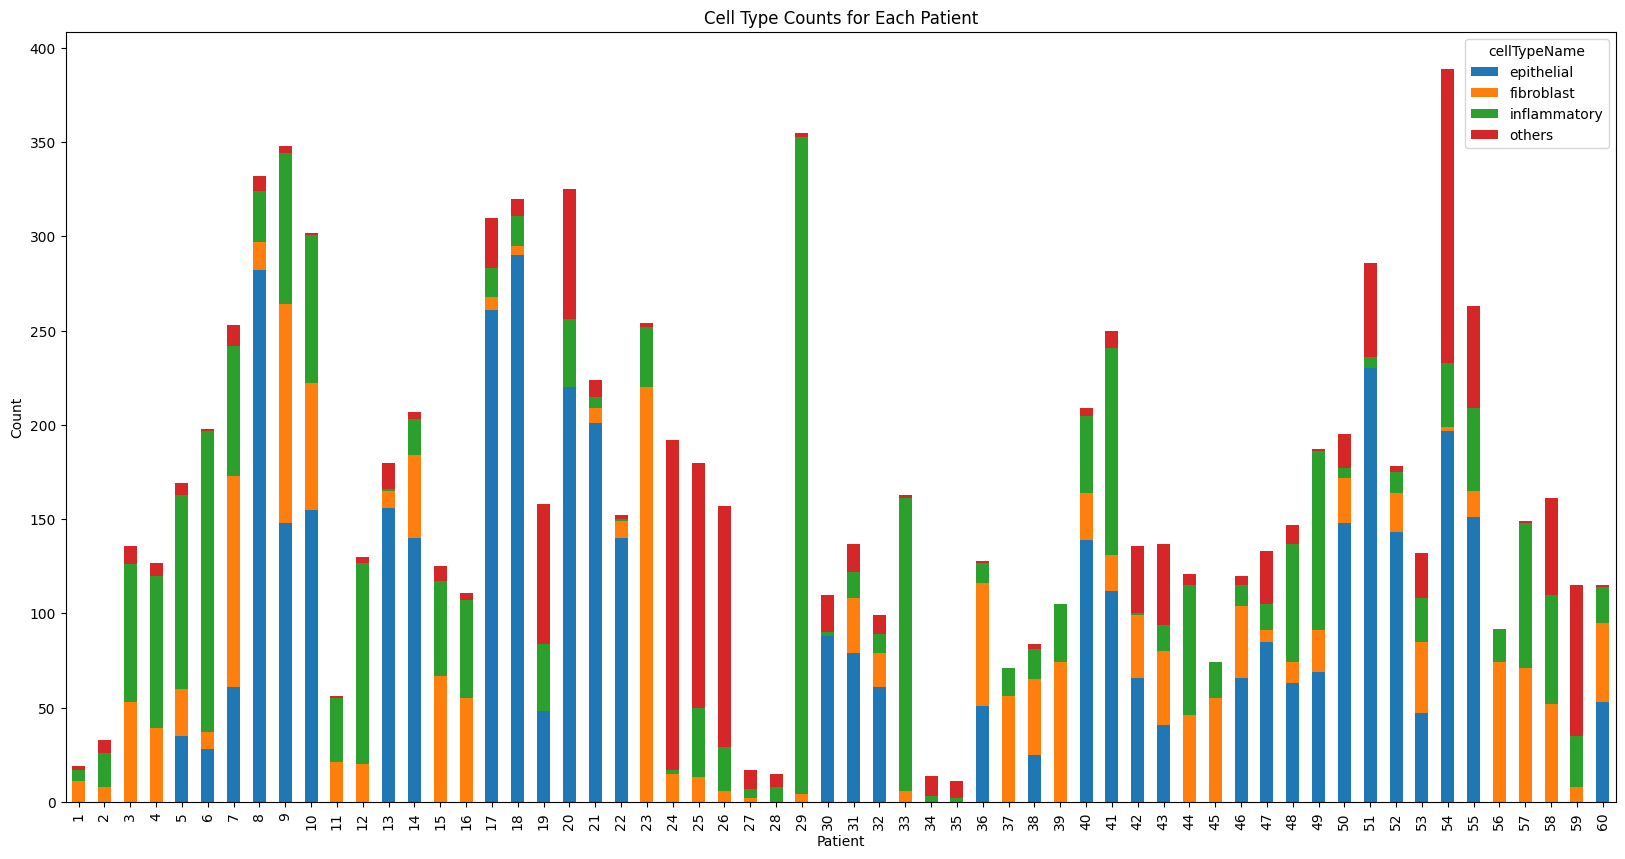

In [6]:
# Get sort counts based on 'patientID' and 'cellTypeName' grouping.
grouped_df = data.groupby(['patientID', 'cellTypeName']).size().reset_index(name='counts')

# Converting data to a form suitable for graphing
pivot_df = grouped_df.pivot(index='patientID', columns='cellTypeName', values='counts')
pivot_df = pivot_df.fillna(0)

# creat stacked bar graph
pivot_df.plot(kind='bar', stacked=True, figsize=(20,10))

# set title and label for X and Y
plt.title('Cell Type Counts for Each Patient')
plt.ylabel('Count')
plt.xlabel('Patient')

# show the graph
plt.show()

## Data Distribution
我们可以从下面的图中发现，`isCancerous`字段中，标记为非癌症和癌症的样本分布并不均匀，即数据存在明显的不平衡。同样，`cellType`字段中，各种细胞类型的分布也存在不平衡的情况。这种不平衡的数据分布可能会对模型的训练产生影响，比如可能会导致模型过于倾向于预测数量较多的类别，从而影响模型在预测较少类别时的性能。由于数据存在明显不平衡所以，我们将通过分配权重的方式来降低不平衡数据集的影响。此外，我们将不考虑患者的因素去划分数据集，我们将保证训练集，测试集和验证集与整体数据集的分布一致。

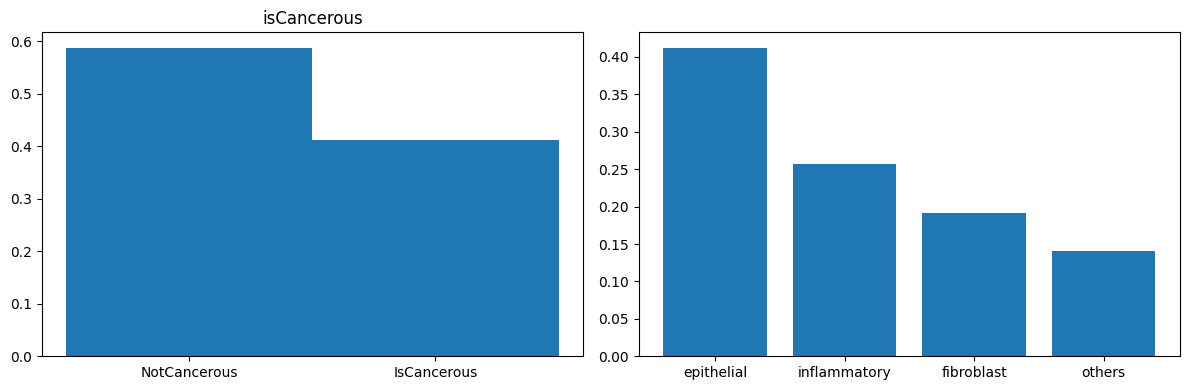

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
weights = np.ones_like(data['isCancerous']) / len(data['isCancerous'])
value_counts = data['cellTypeName'].value_counts(normalize=True)
axs[0].hist(data['isCancerous'], weights=weights, bins=np.array([-0.5, 0.5, 1.5]))
axs[0].set_xticks([0, 1], ['NotCancerous', 'IsCancerous'])
axs[0].set_title('isCancerous')
axs[1].bar(value_counts.index, value_counts.values)
plt.tight_layout()
plt.show()


## Relationship between cell types and cancer cells
我们可以从下面的表格看出，所有标记为`epithelial`的细胞类型都被诊断为癌症，这可能说明`epithelial`类别的细胞具有更高的癌症发生风险。而其他类别的细胞，如`fibroblast`，`inflammatory`和`others`，在我们的数据集中，均未被诊断为癌症。然而，我们并不会单纯的将`epithelial`直接视为癌症或者其他类别的细胞都是被视为非癌症。因为我们无法保证额外的数据集中不存在不是`epithelial`细胞类型的癌症。

In [8]:
cancer_counts = data.groupby('cellTypeName')['isCancerous'].value_counts().unstack()
cancer_counts.fillna(0, inplace=True)
print(cancer_counts)

isCancerous        0       1
cellTypeName                
epithelial       0.0  4079.0
fibroblast    1888.0     0.0
inflammatory  2543.0     0.0
others        1386.0     0.0


## Cell sample display

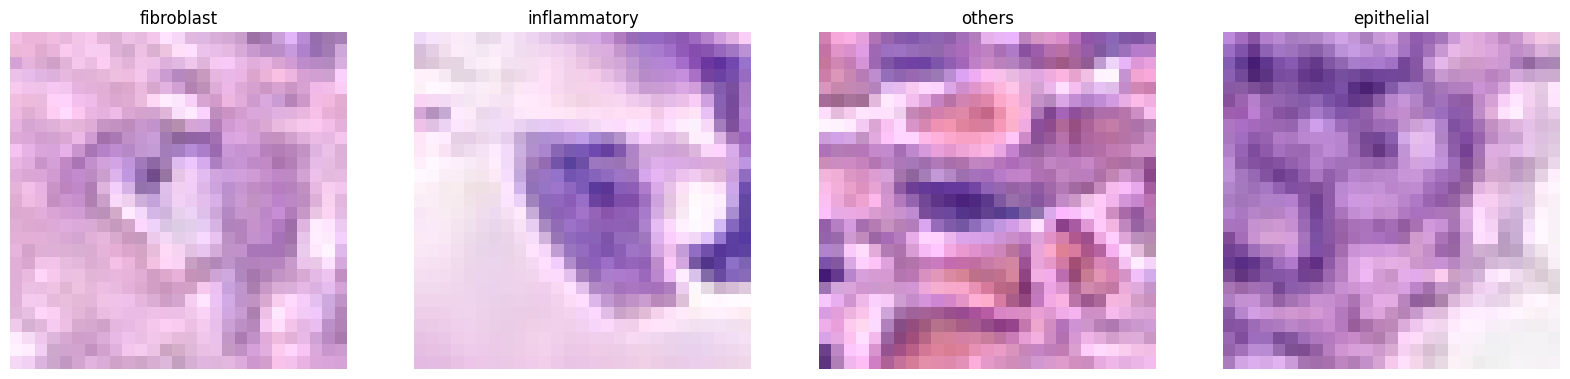

In [9]:
unique_cell_types = data['cellTypeName'].unique()
selected_images = {}

for cell_type in unique_cell_types:
    images_of_cell_type = data[data['cellTypeName'] == cell_type]
    selected_image = images_of_cell_type.sample(n=1).iloc[0]
    selected_images[cell_type] = selected_image['ImageName']

fig, axes = plt.subplots(1, len(unique_cell_types), figsize=(len(unique_cell_types) * 5, 5))

for ax, (cell_type, image_path) in zip(axes, selected_images.items()):
    img = mpimg.imread("./Image_classification_data/patch_images/" + image_path)
    ax.imshow(img)
    ax.set_title(cell_type)
    ax.axis('off')

plt.show()

## 可视化图像增强
下面的图片展示了可视化图像增强前后的区别可以帮助我们更好地理解增强方法对图像的实际效果。我们可以查看它是否可能导致任何不希望的副作用，以及它是否提供了足够的变化来增强模型的泛化能力。

In [10]:
def visualize_augmentation(image, generator, num_augmented_images=5):
    # 将 PIL.Image 对象转换为 NumPy 数组，并扩展维度以适应 ImageDataGenerator
    image_array = np.expand_dims(np.array(image), axis=0)

    # 使用 ImageDataGenerator 生成增强图像
    augmented_images = generator.flow(image_array, batch_size=1)

    # 绘制原始图像和增强图像
    fig, axes = plt.subplots(1, num_augmented_images + 1, figsize=(15, 15))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for ax, aug_image in zip(axes[1:], augmented_images):
        ax.imshow(aug_image[0].astype(np.uint8))
        ax.set_title("Augmented Image")
        ax.axis("off")

        num_augmented_images -= 1
        if num_augmented_images == 0:
            break

    plt.show()

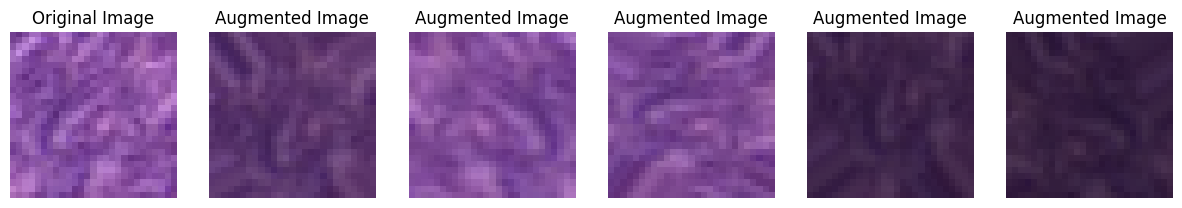

In [11]:
# 随机选择一张图像
selected_image = data.sample(n=1).iloc[0]['ImageName']
image = Image.open("./Image_classification_data/patch_images/" + selected_image)
# 创建 ImageDataGenerator 对象
augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
# 可视化图像增强效果
visualize_augmentation(image, augmentation_generator)

---
# 数据分割
## 训练集、验证集和测试集
在本项目中我使用了训练集、验证集和测试集。首先，将数据的80%划分为训练集加验证集，剩下的20%划分为不可见测试集。这样的划分方式确保了模型在训练过程中有足够的数据进行学习，从而提高模型的准确性和鲁棒性，防止欠拟合。同时，20%的不可见测试数据作为一个独立的数据集用于评估模型的最终性能，有助于了解模型在未见过的数据上的泛化能力，而不仅仅是模型在训练数据上的拟合程度。

接下来，我将训练集加验证集进一步划分，分为训练集（80%）和验证集（20%）。训练集用于训练模型，验证集对我来说非常重要，它可以反应模型在每轮epoch上的表现，从而更合理的判断模型是否存在过拟合或欠拟合。并我们将根据验证集损失的变化来动态降低学习率。

In [12]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
ia.seed(seed_value)

data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

### 拆分数据集分布测试
值得注意的是，训练集和测试集应该有相似的分布，保证训练好的模型在测试集上有很好的泛化能力。如果它们的分布不相似，则测试集不能代表训练集，在测试集上获得的性能指标可能无法真实反映模型在实际应用中的性能。这可能会导致对模型性能的误判。我进行了 Kolmogorov-Smirnov (KS) 测试，通过比较训练集和测试集的每一列来评估它们分布的相似性。零假设声明训练集和测试集的每一列具有相同的分布。如果 p 值小于所选的显着性水平 (0.05)，我们可以拒绝原假设，表明分布存在显着差异。同样，检查训练集和未拆分数据集的分布也很重要。这可以帮助我们确保训练集代表未拆分数据集，并有助于识别训练集和未拆分数据集之间是否存在任何偏差。因此，我还对训练集和未拆分数据集进行了 KS 测试。

In [13]:
def is_same_distribution(datasets_a, datasets_b):
    alpha = 0.05
    p_value_map = dict()
    for column in datasets_a.columns:
        _, p_value = ks_2samp(datasets_a[column], datasets_b[column])
        p_value_map[column] = p_value

    columns_with_p_value_less_than_005 = []
    for column, p_value in p_value_map.items():
        if p_value < alpha:
            columns_with_p_value_less_than_005.append(column)
    return len(columns_with_p_value_less_than_005) == 0, columns_with_p_value_less_than_005

# Make sure the distribution of the training set and the test set are the same
is_same, diff_columns = is_same_distribution(train_data, test_data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the test set.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

# Make sure the distribution of the training set and the test set are the same
is_same, diff_columns = is_same_distribution(train_data, val_data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the validation set.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

# Make sure the distribution of the training set and the overall dataset are the same
is_same, diff_columns = is_same_distribution(train_data, data)
if is_same:
    print("The null hypothesis is accepted for the distribution of both the train set and the entire dataset.")
else:
    print("Columns with p-value less than 0.05:", diff_columns)
    print("It is recommended to replace the seed value")

The null hypothesis is accepted for the distribution of both the train set and the test set.
The null hypothesis is accepted for the distribution of both the train set and the validation set.
The null hypothesis is accepted for the distribution of both the train set and the entire dataset.


### Histograms showing the distribution of the training set, validation set, test set, and overall dataset
我们从下面的图可以看出训练集、验证集和测试集的数据分布相近。这有助于确保模型在各个数据集上表现稳定，并且有较好的泛化能力。当训练、验证和测试数据具有相似的分布时，模型更容易从训练集中学习到的模式在验证集和测试集上得到验证，从而提高模型在未知数据上的预测性能。这也有助于我们更准确地评估模型的性能，避免由于数据分布不一致导致的性能差异。

Text(0.5, 1.0, 'cellType')

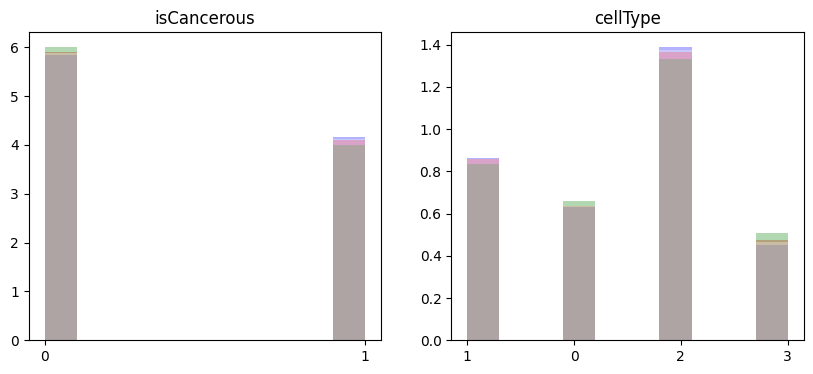

In [14]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
axes[0].hist(val_data['isCancerous'], alpha=0.3, color='r', label='validation', density=True)
axes[0].hist(test_data['isCancerous'], alpha=0.3, color='g', label='Test', density=True)
axes[0].hist(data['isCancerous'], alpha=0.3, color='w', label='overall',  density=True)
axes[0].set_title('isCancerous')
axes[1].hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
axes[1].hist(val_data['cellType'], alpha=0.3, color='r', label='validation', density=True)
axes[1].hist(test_data['cellType'], alpha=0.3, color='g',label='Test', density=True)
axes[1].hist(data['cellType'], alpha=0.3, color='w', label='overall',  density=True)
axes[1].set_title('cellType')

### Leakage test
此外，我们需要确保训练集和测试集之间没有重叠样本。这是因为重叠样本会导致数据泄漏，当模型在训练过程中无意中访问了测试集中的信息时，就会发生这种情况。当发生数据泄漏时，模型在训练过程中可能会过度拟合某些测试集数据，从而导致在测试集上表现看似出色。然而，这种过于乐观的表现可能无法准确反映模型处理现实世界未知数据的能力，导致在实际应用中表现不佳。

In [15]:
combined_df = pd.concat([train_data, test_data], axis=0, ignore_index=True)
duplicated_rows = combined_df.duplicated()
if duplicated_rows.any():
    print("The training set and the test set have the same instances: ", combined_df[duplicated_rows])
else:
    print("The training set and the test set do not have the same instances")

The training set and the test set do not have the same instances


---
# 分配类别权重
正如上面所说，由于类别的分布不同所以我们将在后面的改进模型中添加权重，从而降低不平衡数据带来的影响。对于基线模型来说，我们将不使用权重。因为我们想看到没有类别权重时模型的原始性能。然后在增强的模型中观察添加类别权重后模型性能的提升情况。

In [16]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

---
# 超参数汇总
本段率将汇总在本任务中所需要的所有超参数。首先是所有神经网络需要的超参数。

1. **学习率**：学习率决定了模型在优化过程中更新权重的速度。过高的学习率可能导致模型在最优解周围快速震荡，而无法收敛；过低的学习率可能导致训练过程过于缓慢，或者在达到最优解之前就停止。

2. **批次大小**：批次大小是每次训练迭代中用于更新模型权重的样本数。它对训练速度和模型性能都有影响。较大的批次可能导致训练速度更快，但可能陷入局部最优；较小的批次可能使模型能更好地探索参数空间，但训练速度可能会慢一些。

3. **神经元数量**：在每个隐藏层中的神经元数量影响模型的复杂性。过多的神经元可能导致过拟合，即模型在训练数据上表现良好，但在未知数据上表现较差；过少的神经元可能导致模型无法学习数据的复杂模式。

4. **隐藏层数量**：隐藏层数量也影响模型的复杂性。过多的隐藏层可能导致过拟合，而过少的隐藏层可能使模型无法学习数据的复杂模式。

5. **激活函数**：激活函数决定了神经元的输出和梯度更新。不同的激活函数有不同的特性，比如ReLU激活函数可以缓解梯度消失问题，Sigmoid和Tanh则在某些情况下更适合。

6. **正则化技术**：如L1/L2正则化和dropout，它们可以帮助防止模型过拟合。选择不同的正则化技术或组合以及其正则化强度。

7. **优化器**： 决定模型训练过程中参数更新的方式。优化器的主要任务是最小化损失函数，这是通过改变模型的权重来实现的。常见的优化器有SGD（随机梯度下降）、RMSprop、Adam等。

8. **训练周期数**：每一个训练周期都表示着模型看过所有训练样本一次。太少的训练周期可能会导致模型在训练集上欠拟合，而太多的训练周期可能会导致模型在训练集上过拟合，即模型在训练集上的表现很好，但在测试集或者新的数据上的表现就会变差。

其次是CNN，还有一些额外的关键超参数：

1. **卷积核大小**：卷积核大小影响了模型可以捕捉到的空间模式的尺度。较大的卷积核可以捕捉到更大尺度的模式，但可能会忽视一些细节；较小的卷积核可以捕捉到更精细的模式，但可能会忽视一些更大尺度的结构。

2. **卷积层数量和卷积层的过滤器数量**：这些参数影响了模型的深度和宽度，以及模型能捕捉到的特征种类的数量。

3. **池化层**：池化层用于降低特征的维度并提取主要特征。它有助于减少计算量和模型的参数数量，从而缓解过拟合。

4. **步幅**：步幅决定了卷积核在输入特征图上移动的距离。大步幅可以减少输出特征图的尺寸，从而减少计算量，但可能会导致模型损失一些信息。

5. **填充**：填充是为了在进行卷积操作时保持特征图的空间尺寸不变。它可以帮助模型更好地学习图像的边界区域。

最后是本任务其他需要调整的超参数：
1. **一致性损失权重**： 本任务通过FixMatch对模型进行增强，FixMatch中需要对弱增强和强增强图片计算一致性损失，这个超参数用于控制一致性损失的强度，类似于正则化强度。

2. **概率阈值**：在FixMatch算法中，概率阈值是一个关键的超参数。如果预测结果的概率超过设定的阈值，那么这个预测结果就被认为是"自信的"，并被用作伪标签来更新模型。阈值设置过低可能会引入大量错误的伪标签，导致模型训练偏离正确方向；而阈值设置过高则可能使得大部分无标签数据得不到有效利用。

3. **图像增强技术数量**：本任务通过控制图像增强技术的数量来对图像进行增强，从而增加模型训练时的样本多样性，使其具有更强的泛化能力和鲁棒性。

---
# Data Generator for the Baseline Model
下面的代码片段为我们的基线模型准备了数据生成器。数据生成器用于批量加载和预处理图像，使它们准备好输入模型进行训练、验证和测试。此外，对于接下来的验证集和测试集的数据生成器也会被适用于改进模型，因为他们不需要进行额外的图像增强。

我们使用 Keras 的 ImageDataGenerator 类，它使我们能够高效地从磁盘加载图像并应用实时数据增强。然而，在这种情况下，我们只将图像的像素值从范围 [0, 255] 重新缩放到范围 [0, 1]。这种归一化有助于提高神经网络的性能和稳定性。当然，对于不可见的测试集和验证集，同样需要进行图像归一化处理，这是因为测试集也是用来评估模型的性能，与训练集和验证集一样，需要使用相同的预处理方法，以确保测试结果的准确性和可比性。对于批大小，它是我们调节的超参数，并且我们将32作为我们的最终大小。我们也尝试了其他的超参数，即使更大的超参数带来了更快的训练速度，但模型的性能出现了一定程度的下降。更小的批大小也没有带来更好的模型性能。与此同时，我们为了保持训练集、验证集和测试集的一致性，我们也将验证集和测试集的批大小设置为32。

接下来，我们使用 ImageDataGenerator 的 flow_from_dataframe 方法直接从指定目录读取图像，在本例中为 `./Image_classification_data/patch_images`。它使用之前创建的数据框来获取图像文件名（来自`ImageName`列）及其相应的标签（来自`isCancerous`和`cellType`列）。

`flow_from_dataframe` 方法中的 `class_mode` 参数在读取`isCancerous`标签时设置为`binary`，在读取`cellType`标签时设置为`categorical`，因为`isCancerous`是一个二元分类任务，而`cellType`是一个多类分类任务。重要的是，`categorical`模式将自动将标签进行独热编码，这对多类分类任务是必需的。并且为了保证我们评估模型的有效性，我将`shuffle`设置为`False`。这是因为我们使用model的`predict`方法并`shuffle`设置为`True`时，`predict`方法内部会进行打乱，使得我们无法将正确的标签与训练的样本正确对应。

训练集数据生成器`train_isCancerous_generator`和`train_cellType_generator`将专门用于基线模型。稍后，我们将为改进的模型创建新的数据生成器，我们将在其中应用更复杂的数据增强技术来进一步提高模型的性能。从而比较进行复杂的数据增强技术的图像和只进行归一化的图像对模型带来的性能改善。

In [17]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.
Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


---
# Performance evaluation methods
In this project, the performance of multiple models was evaluated using several widely adopted classification metrics, including cross-entropy loss, accuracy, precision, recall, and F1 score. These metrics were employed to compare the performance differences between the models.

Cross-Entropy Loss is a commonly used metric for classification tasks that measures the difference between the predicted probability distribution and the true distribution of the target variable. A lower cross-entropy loss value indicates higher prediction accuracy. However, this metric alone might not be sufficient to understand the model's performance in all aspects, especially when dealing with imbalanced or multi-category datasets.

Accuracy is the ratio of the number of correct predictions to the total number of predictions made by the model. While accuracy can provide a general sense of the model's performance, it might not be as informative for imbalanced datasets or multi-category classification tasks.

Precision is a measure of the model's ability to correctly identify positive instances, defined as the ratio of true positives to the sum of true positives and false positives. Recall is a measure of the model's ability to identify all positive instances, defined as the ratio of true positives to the sum of true positives and false negatives. The F1 Score is the harmonic mean of precision and recall, providing a balanced evaluation of both the model's ability to identify positive instances and its ability to identify all positive instances.

The custom F1-score class was implemented to calculate the F1 score for multi-category classification tasks, as the TensorFlow framework itself does not have a built-in multi-class F1-score. Multi-Precision is a custom metric derived from the F1-score class, which calculates the average precision across all categories. Multi-Recall is another custom metric derived from the Multi-Category F1 Score class, which calculates the average recall across all categories. The custom Multi-Category F1 Score is a harmonic mean of multi-precision and multi-recall, providing a balanced evaluation of both the model's ability to identify positive instances and its ability to identify all positive instances across multiple categories. Like multi-precision and multi-recall, the multi-category F1 score can be calculated as micro, macro, or weighted. We will use the weighted method to calculate, because we focus on the overall performance, and the data is imbalanced as found by EDA. So the way we choose weighted is reasonable.

ROC (Receiver Operating Characteristic) curve is a graphical representation that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups (diseased/normal). In multi-class scenarios, we can also compute ROC curves for each class against the rest and then derive a weighted average ROC curve. This method of evaluation provides a holistic view of the model's performance across all classes, not just a single one, which can be particularly valuable in tasks with more than two categories. However, it's important to note that calculating a weighted average ROC curve doesn't directly result in an actual ROC curve, but rather a weighted average AUC (Area Under the Curve) value. Each ROC curve represents the relationship between the True Positive Rate and False Positive Rate at a certain threshold, so we can't directly compute a weighted average ROC curve. In practice, we usually draw individual ROC curves for each class and then calculate a weighted average AUC value. This AUC value can be considered a comprehensive measure of the performance of all the ROC curves across classes.

AUC-ROC is considered a more advanced metric as it provides a more comprehensive view of model performance across all possible classification thresholds, rather than a single point estimate like accuracy, precision or recall. This means that it takes into account both the model's sensitivity (recall) and its specificity (precision), and doesn't require selecting a specific threshold in advance. AUC is particularly useful in imbalanced datasets, where a model's ability to distinguish between classes is more informative than its overall accuracy.

In conclusion, by using the metrics of accuracy, cross-entropy loss, precision, recall, F1 score and AUC-ROC, we can gain a more complete and nuanced understanding of the performance of our models. These metrics allow for a comprehensive comparison and evaluation of the models, capturing different aspects of the model's performance and enabling us to select the most suitable model for our task. These metrics are crucial for both binary and multi-category classification tasks, where different aspects of model performance need to be considered.

In [18]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiCategoryF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_category=4, average='weighted', name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_category
        self.average = average
        self.confusion_matrix = self.add_weight(name="confusion_matrix", shape=(num_classes, num_classes), initializer="zeros", dtype=tf.float32)


    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        current_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        self.confusion_matrix.assign_add(current_confusion_matrix)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fp = tf.reduce_sum(self.confusion_matrix, axis=0) - tp
        fn = tf.reduce_sum(self.confusion_matrix, axis=1) - tp

        precision_per_class = tp / (tp + fp + tf.keras.backend.epsilon())
        recall_per_class = tp / (tp + fn + tf.keras.backend.epsilon())

        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp))
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn))
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
            recall = tf.reduce_mean(recall_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            precision = tf.reduce_sum(precision_per_class * weights) / tf.reduce_sum(weights)
            recall = tf.reduce_sum(recall_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")

        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.confusion_matrix.assign(tf.zeros_like(self.confusion_matrix))

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes": self.num_classes, "average": self.average})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class MultiPrecision(MultiCategoryF1Score):
    def __init__(self, num_category=4, average='weighted', name='precision', **kwargs):
        super().__init__(num_category, average, name, **kwargs)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fp = tf.reduce_sum(self.confusion_matrix, axis=0) - tp
        precision_per_class = tp / (tp + fp + tf.keras.backend.epsilon())
        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp))
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            precision = tf.reduce_sum(precision_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")
        return precision


class MultiRecall(MultiCategoryF1Score):
    def __init__(self, num_category=4, average='weighted', name='recall', **kwargs):
        super().__init__(num_category, average, name, **kwargs)

    def result(self):
        tp = tf.linalg.diag_part(self.confusion_matrix)
        fn = tf.reduce_sum(self.confusion_matrix, axis=1) - tp
        recall_per_class = tp / (tp + fn + tf.keras.backend.epsilon())
        if self.average == 'micro':
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn))
        elif self.average == 'macro':
            recall = tf.reduce_mean(recall_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(self.confusion_matrix, axis=1)
            recall = tf.reduce_sum(recall_per_class * weights) / tf.reduce_sum(weights)
        else:
            raise ValueError("Invalid average type. Accepted values are: 'micro', 'macro', 'weighted'")
        return recall

In [19]:
def binary_roc_curve(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    roc_auc = roc_auc_score(y_true, y_pred)  # 计算AUC值

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def categorical_roc_curve(model, generator):
    y_true = np.array(generator.classes)
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    y_pred_bin = model.predict(generator)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    weights = []

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        weights.append(np.sum(y_true == i))

    weighted_roc_auc = np.average(list(roc_auc.values()), weights=weights)

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))

    plt.plot([0, 1], [weighted_roc_auc]*2, 'b--', label='Weighted Avg ROC curve (area = %0.2f)' % weighted_roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

---
# 模型实现
在这个任务中，我们需要对两个值进行预测，一个是判断细胞图像是否为癌细胞，另一个是判断细胞类型，即分类任务。我将使用人工神经网络对其进行建模。根据作业要求，我将使用简单的MLP作为基线模型并且卷积神经网络作为我提升模型的。

## 二分类任务MLP基线模型
在这个任务中，我们需要预测图像是否为癌症，即目标值是二分的。我将使用简单的Multilayer perceptron (MLP)模型对其进行建模，从而确定模型存在的局限以及比较与改进模型之间的性能差异。MLP是一种人工神经网络，它由多层的感知器或神经元组成，每层都全连接到下一层。这些层通常分为三种，输入层、隐藏层和输出层。

我们可以从下面的模型首先对图像进行简单的预处理。由于MLP模型不能直接处理图像数据，我们需要将其转化为一维向量。接下来是隐藏层，我们可以根据问题的复杂性选择多个隐藏层，每层有不同数量的神经元。最后是输出层，由于我们的任务是二分类，所以输出层只有一个神经元。它将输出一个值，表示图像为癌症的概率。

根据作业要求，我们不仅需要完成基线模型而且还尝试使用其他技术来构建改进模型。基线模型将用于与改进模型进行比较从而观察模型性能的差异。

由于我们是二分类任务所以我们使用binary crossentropy loss 函数。

### Problem formulation
对于该任务损失函数使用二元交叉熵 (binary cross entropy)，则目标函数可以表示为：

$$\min_{h \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^{n} -[y_i \log(h(\mathbf{x}_i)) + (1-y_i) \log(1-h(\mathbf{x}_i))]$$

这里 $\mathcal{H}$ 是假设空间，是所有可能的 MLP 函数的集合，其中 $h(\mathbf{x}_i)$ 是 MLP 对于输入 $\mathbf{x}_i$ 的预测值，$y_i$ 是真实标签（0 或 1）。

对于假设空间$\mathcal{H}$ ，由于 MLP 涉及到更复杂的函数形式，所以我们把 $\mathcal{H}$ 看作是由所有可能的 MLP 模型（具有各种可能的参数、层数和节点数）构成的函数空间。

### 模型描述
对于判断是否为癌症的二分类任务。输入层将输入图像展平为一个一维张量，尺寸为 (27, 27, 3)。之后进入全连接层：包含 512 个神经元，使用 ReLU 激活函数。输出层：包含 1 个神经元，使用 Sigmoid 激活函数来得到癌症分类的概率。由于我们现在构建简单的基线模型所以我们将使用一层隐藏层。隐藏层的感知器数量为512。值得注意的是隐藏层的感知器数量和层数以及激活函数的选择都是需要调整的超参数。对于27x27x3的图像，输入层有2187个神经元。在这种情况下，使用512个神经元的隐藏层我们认为是一个合理的选择。这个数目足够大，能够学习到输入数据中的复杂模式，同时也足够小，以降低过度拟合的风险。此外，512是2的9次方，对于许多深度学习框架来说，使用2的幂作为层的大小可以提高计算效率。

In [20]:
input_shape = (27, 27, 3)
baseline_binary = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
baseline_binary.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 512)               1120256   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1120769 (4.28 MB)
Trainable params: 1120769 (4.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 编译模型
正如我们上文所说，我们使用二元交叉熵损失函数作为损失函数。Adam作为本次优化器，Adam已经包含了动量，它可以防止陷入局部最小值，并且它还具备学习率衰减，使得模型在训练后期能够更精细地进行参数更新。此外，学习率我们使用默认学习率(0.001)，我们想查看在基线模型的表现从而在之后的模型中调整学习。与此同时，我们将记录损失，准确度，Precision，Recall和F1Score，这允许我们可以模型在训练时性能的变化。

In [21]:
baseline_binary.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy',
                                 tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall'),
                                 F1Score()])

### 训练模型
训练周期也是我们需要调节的超参数。我们将更加模型的表现，来逐步调整学习率。

In [22]:
epochs = 100
history_baseline_binary = baseline_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size
)

Epoch 1/100


2023-05-13 14:04:47.430136: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


189/197 [===========================>..] - ETA: 0s - loss: 0.5648 - accuracy: 0.7492 - precision: 0.7211 - recall: 0.6458 - f1_score: 0.6814

2023-05-13 14:04:48.489224: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 1s 5ms/step - loss: 0.5578 - accuracy: 0.7529 - precision: 0.7267 - recall: 0.6535 - f1_score: 0.6882 - val_loss: 0.3627 - val_accuracy: 0.8559 - val_precision: 0.8213 - val_recall: 0.8289 - val_f1_score: 0.8251
Epoch 2/100
197/197 [==============================] - 1s 5ms/step - loss: 0.3670 - accuracy: 0.8417 - precision: 0.8192 - recall: 0.7958 - f1_score: 0.8073 - val_loss: 0.3290 - val_accuracy: 0.8546 - val_precision: 0.8139 - val_recall: 0.8367 - val_f1_score: 0.8252
Epoch 3/100
197/197 [==============================] - 1s 5ms/step - loss: 0.3529 - accuracy: 0.8481 - precision: 0.8212 - recall: 0.8128 - f1_score: 0.8170 - val_loss: 0.3246 - val_accuracy: 0.8654 - val_precision: 0.8529 - val_recall: 0.8118 - val_f1_score: 0.8319
Epoch 4/100
197/197 [==============================] - 1s 5ms/step - loss: 0.3312 - accuracy: 0.8581 - precision: 0.8312 - recall: 0.8280 - f1_score: 0.8296 - val_loss: 0.4940 - val_accuracy: 0.7768 - val_precis

可视化训练过程

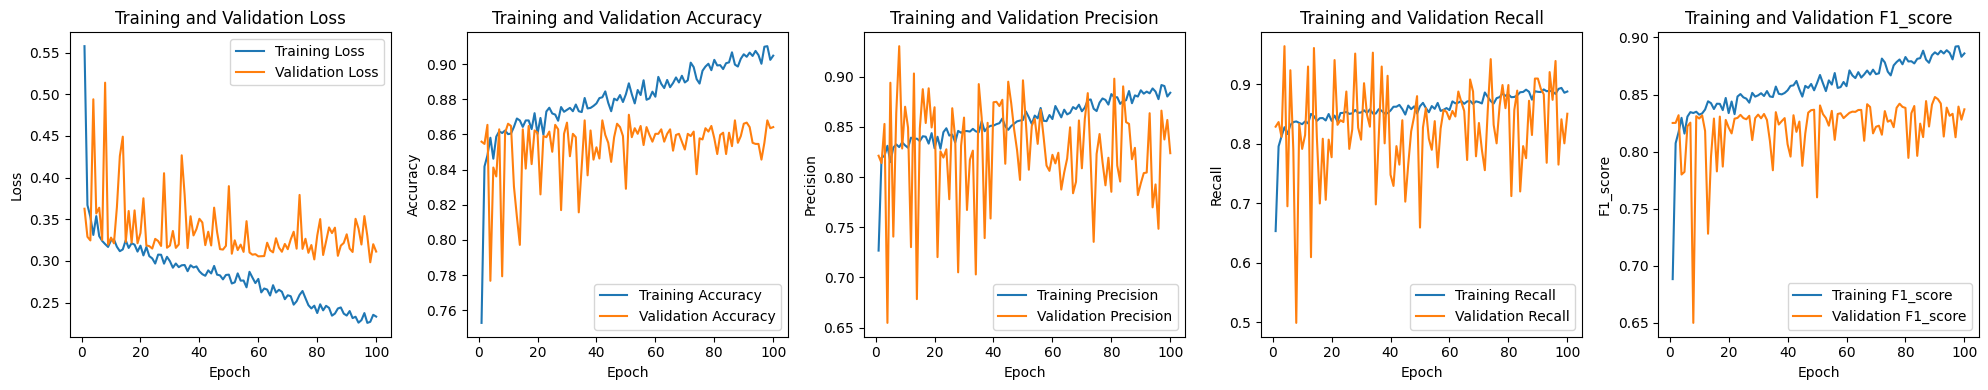

In [23]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_baseline_binary.history.keys() if not key.startswith("val_")]
_, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_baseline_binary.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_baseline_binary.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

在不可见数据集上的表现

In [24]:
baseline_binary.evaluate(test_isCancerous_generator)

45/62 [====================>.........] - ETA: 0s - loss: 0.2833 - accuracy: 0.8854 - precision: 0.8468 - recall: 0.8718 - f1_score: 0.8591

2023-05-13 14:06:21.699505: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 0s 4ms/step - loss: 0.3004 - accuracy: 0.8783 - precision: 0.8345 - recall: 0.8673 - f1_score: 0.8506


[0.3004201352596283,
 0.8782828450202942,
 0.8345499038696289,
 0.8672566413879395,
 0.8505889177322388]

ROC曲线和AUC值

45/62 [====================>.........] - ETA: 0s

2023-05-13 14:06:21.948671: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 0s 4ms/step


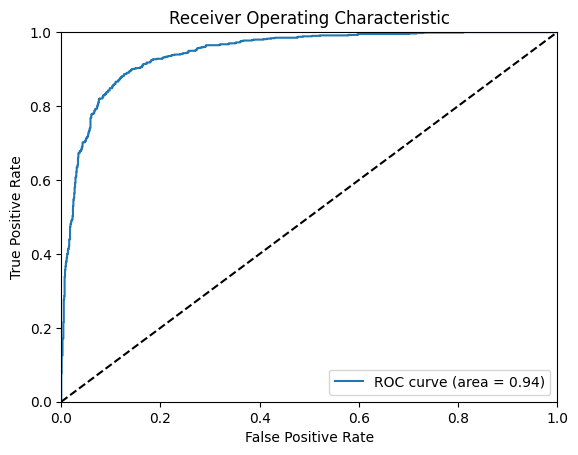

In [25]:
binary_roc_curve(baseline_binary, test_isCancerous_generator)

### 总结模型性能
根据给出的性能指标，我们可以对模型的性能进行如下分析：
二分类基线模型似乎在训练集上表现良好，准确性、精确度、召回率和 F1 分数都相对较高。但是，还必须考虑验证集的结果，以查看二分类基线模型是否能够很好地泛化到未见数据。
然而，训练和验证结果之间似乎存在明显的差距，这是过度拟合的迹象。二分类基线可能对训练数据的学习太好，因此无法推广到新的、看不见的数据。
此外，另一个潜在的问题是模型的查全率（recall）和查准率（precision）在训练和验证阶段都表现非常不稳定。这可能表明模型在分类正例和反例时可能存在困难，这说明仍需要进一步优化以提高其泛化能力和收敛稳定性。
我们还注意到验证集的损失似乎在波动并且没有显示出一致的下降趋势，这又可能表明过度拟合并且后期的的学习率可能需要调整。
从ROC曲线来看，模型已经具备一定的分类能力，其AUC值达到0.94，表明模型在区分正负样本上的能力较强。然而，理想的ROC曲线应该更靠近图像的左上角，这意味着模型可以在保持高召回率的同时，尽可能降低假阳性率。因此，虽然现有模型的表现已经相对不错，但还是存在一定的提升空间。

### Improvement
这里我们将在前面所有内容的基础上总结一下对Baseline模型可能改进的探索。首先根据EDA我们发现了数据不平衡的问题，之前我们在分割数据的部分我通过分配类别权重来抑制不平衡数据集的影响。其次，根据我们基线模型的表现，我们发现了模型是过拟合的，它无法在验证集和不可见测试集上体现出泛化能力。因此，我们需要通过改进模型，添加正则化以及Dropout层等方式来解决过拟合的问题。并且批归一化层也会被使用，它同样可以增加模型的泛化能力的同时加速模型收敛速度。同时，我们将在提升模型中使用图像增强技术，这项技术可以增多训练数据从而降低过拟合的风险。第三，我们还发现基线模型收敛并不稳定，所以我们将降低学习率并且根据验证集损失值的变化动态降低学习率，从而保证模型稳定的收敛。

## 多分类任务MLP基线模型
在这个任务中，我们需要预测细胞图像的类别，即目标值是多分类问题。我们仍然使用简单的MLP模型作为基线模型。与二分类的MLP模型相比，多分类的MLP模型区别在于输出层的激活函数从sigmoid改为softmax，其余保持不变。值得注意的是我们将改变我们的损失函数从binary crossentropy loss 函数改为 categorical crossentropy函数。因此我们的目标函数也需要进行改变。因为我们的任务从二分类改为多分类。

### Problem formulation
对于使用多层感知器 (MLP) 进行多分类任务，损失函数使用多类别交叉熵 (categorical crossentropy)，其目标函数可以表示为：

$$\min_{h \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^{n} \left(-\sum_{c=1}^{C} y_{ic} \log(h_{ic}(\mathbf{x}_i))\right)$$

这里 $\mathcal{H}$ 是假设空间，是所有可能的 MLP 函数的集合，其中 $h_{ic}(\mathbf{x}_i)$ 是 MLP 对于输入 $\mathbf{x}_i$ 的预测值（类别 $c$），$y_{ic}$ 是真实标签的 one-hot 编码（对应类别 $c$ 的值）。

对于假设空间$\mathcal{H}$，与上文的解释一样，$\mathcal{H}$ 可以被认为是所有可能的 MLP 模型（具有各种可能的参数、层数和节点数）构成的函数空间。

### 模型描述
该模型结构于二分类模型基本一致。
与二分类基线模型相比，我们将输出层改为softmax激活函数，使其应用于多分类。

In [26]:
num_classes = 4
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

### 编译模型
对于多分类任务我们使用交叉熵损失最为本次训练的损失函数。我们仍然使用Adam作为优化器。并且记录与二分类基线模型相同的度量。其中Precision，Recall和F1Score是通过weighted方式计算的，从而应用与多分类。

In [27]:
baseline_categorical.compile(loss='categorical_crossentropy',
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=['accuracy',
                                      MultiPrecision(),
                                      MultiRecall(),
                                      MultiCategoryF1Score(num_category=4)])

### 训练模型

In [28]:
epochs = 100
history_baseline_categorical = baseline_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size
)

Epoch 1/100


2023-05-13 14:06:22.328023: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


189/197 [===========================>..] - ETA: 0s - loss: 1.3194 - accuracy: 0.5319 - precision: 0.4867 - recall: 0.5319 - f1_score: 0.5083

2023-05-13 14:06:23.655279: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 2s 6ms/step - loss: 1.3156 - accuracy: 0.5317 - precision: 0.4864 - recall: 0.5317 - f1_score: 0.5080 - val_loss: 1.2245 - val_accuracy: 0.4764 - val_precision: 0.4630 - val_recall: 0.4764 - val_f1_score: 0.4696
Epoch 2/100
197/197 [==============================] - 1s 5ms/step - loss: 0.9453 - accuracy: 0.6290 - precision: 0.5928 - recall: 0.6290 - f1_score: 0.6104 - val_loss: 0.9390 - val_accuracy: 0.6409 - val_precision: 0.5737 - val_recall: 0.6409 - val_f1_score: 0.6054
Epoch 3/100
197/197 [==============================] - 1s 5ms/step - loss: 0.8547 - accuracy: 0.6649 - precision: 0.6288 - recall: 0.6649 - f1_score: 0.6463 - val_loss: 0.8272 - val_accuracy: 0.6754 - val_precision: 0.6007 - val_recall: 0.6754 - val_f1_score: 0.6359
Epoch 4/100
197/197 [==============================] - 1s 5ms/step - loss: 0.8462 - accuracy: 0.6668 - precision: 0.6325 - recall: 0.6668 - f1_score: 0.6492 - val_loss: 0.8262 - val_accuracy: 0.6684 - val_precis

可视化训练过程

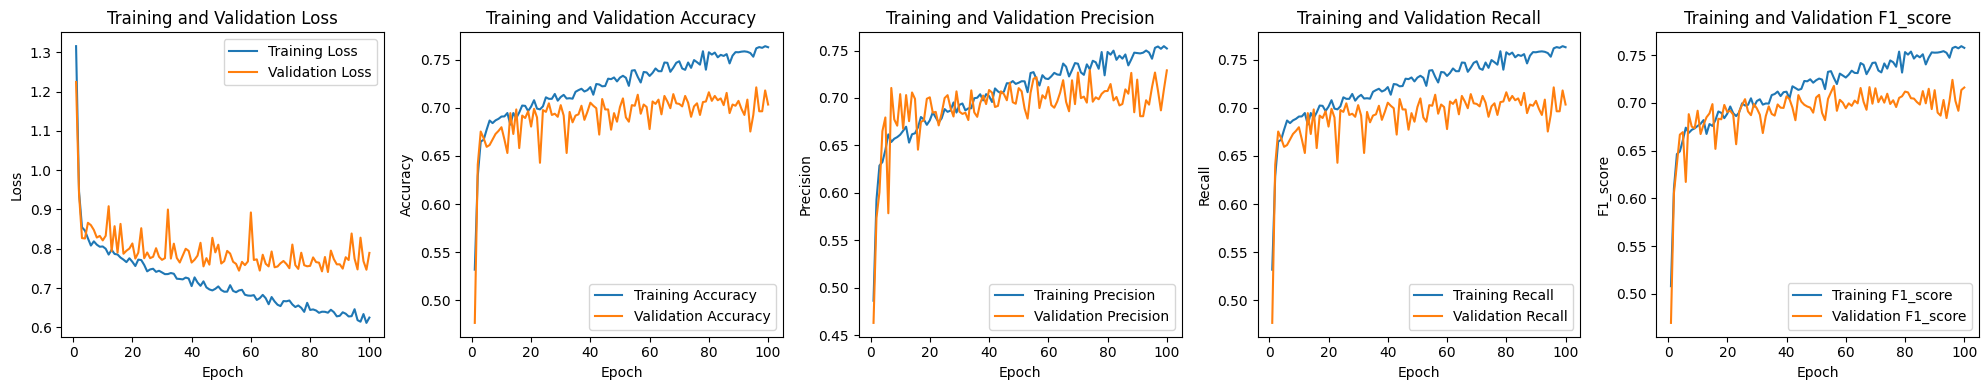

In [29]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_baseline_categorical.history.keys() if not key.startswith("val_")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_baseline_categorical.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_baseline_categorical.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

在不可见数据集上的表现

In [30]:
baseline_categorical.evaluate(test_cellType_generator)

45/62 [====================>.........] - ETA: 0s - loss: 0.8193 - accuracy: 0.7167 - precision: 0.7298 - recall: 0.7167 - f1_score: 0.7232

2023-05-13 14:07:57.207744: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 0s 4ms/step - loss: 0.8358 - accuracy: 0.7091 - precision: 0.7165 - recall: 0.7091 - f1_score: 0.7128


[0.8358175158500671,
 0.7090908885002136,
 0.7164575457572937,
 0.7090908885002136,
 0.7127551436424255]

ROC曲线和AUC值

46/62 [=====================>........] - ETA: 0s

2023-05-13 14:07:57.461719: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 0s 3ms/step


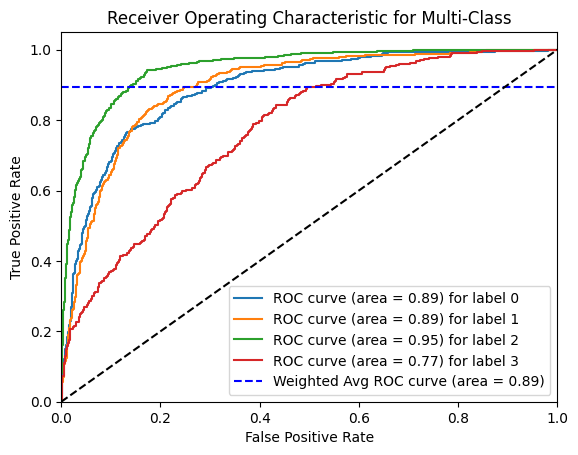

In [31]:
categorical_roc_curve(baseline_categorical, test_cellType_generator)

### 总结模型性能
多分类基线模型似乎在训练集上表现欠佳，准确性、精确度、召回率和 F1 分数都相对较低。并且在验证集集上的性能表现更差。
与此同时，我们可以从损失的变化图中发现，训练和验证结果之间似乎存在明显的差距，这是过度拟合的迹象。
与二分类基线模型类似，验证集的损失似乎在波动并且下降趋势非常缓慢。
我们可以从准确度，precision，recall和f1_score的趋势图中看出，模型在后期时仍然不能稳定收敛。
此外，模型在不可见测试的表现也让人觉得的差强人意。在不可见测试集上f1分数只有大约0.71。
最后，从ROC曲线来看，我们的模型在不同类别上的表现有所差异。特别是最好一个类别，模型的AUC值为0.77，这相对于其他类别来说较低，说明模型在处理这个类别的任务上存在一定的困难。
模型的加权平均AUC为0.89，这是一个较好的分数。然而，我们也需要注意到，模型在处理第四个类别的任务上存在一定的挑战。我们将在提升模型中进一步优化模型，尤其是在处理第四个类别的任务上，以提高模型的整体性能。

### Improvement
对于改进策略与二分类模型的改进策略类似。

---
# 增强模型
改进模型我们将使用卷积神经网络(CNN)。CNN是一种特殊类型的神经网络，主要用于处理具有网格结构的数据，例如图像。CNN的特点是其特殊的层次结构和权重共享机制。CNN的每一层都由多个卷积核构成，每个卷积核都能学习到输入数据的不同特征，这使得CNN能够捕捉到数据的局部空间关联性。所以CNN通过权重共享机制减少了模型的参数数量，这不仅降低了计算复杂度，还有助于防止过拟合。

## Image Augmentation and Data Generator
As we said before, In order to improve the baseline model's performance and increase its ability to generalize, we introduce image augmentation techniques. These techniques apply random transformations to the images, such as rotation, shifting, shearing, and flipping, which can help the model learn more robust features and reduce overfitting.

To achieve this, we have enhanced the functionality of the existing `ImageDataGenerator` class provided by Keras. Our custom data generator, called `CustomImageDataGenerator`, randomly selects a specified number of augmentations each time an image is processed. By introducing this approach, we introduce more diversity into the training data, thereby enhancing the model's ability to generalize to unseen examples. The number of augmentations chosen has become a hyperparameter that requires tuning. We experimented with different values, including 3, 4, and 5, and observed that using 4 augmentations yielded better generalization compared to using 3. However, increasing the number to 5 did not bring significant improvements over 4.

In the `CustomImageDataGenerator` class, we override the `apply_transform` method. This method randomly selects `num_augmentations` transformations from a list of possible augmentations each time an image is processed.

Next, we instantiate this custom data generator and specify the types of transformations and their ranges. In this case, we allow the images to be rotated, shifted in width and height, sheared, zoomed, brightness adjusted, and flipped horizontally and vertically. The `fill_mode` parameter is set to 'nearest', which fills in any new pixels created by the transformations with their nearest neighbors. So we choose 4 as the hyperparameter for the number of augmentations.

Finally, we create the data generators for training the 'isCancerous' and 'cellType' models. These generators will read the images from the disk and apply the specified augmentations on the fly.
Through the use of this custom image data generator, we aim to increase the diversity of the training data, and thus improve the model's ability to generalize to unseen data.

In [32]:
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

    def apply_transform(self, x, transform_parameters):
        augmentations = [
            "theta",
            "tx",
            "ty",
            "shear",
            "zx",
            "zy",
            "flip_horizontal",
            "flip_vertical",
            "brightness",
        ]

        selected_augmentations = random.sample(augmentations, self.num_augmentations)
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items() if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

train_datagen = CustomImageDataGenerator(
    num_augmentations=4,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 6332 validated image filenames belonging to 2 classes.
Found 6332 validated image filenames belonging to 4 classes.


## 学习率控制器
正如我们上文所说的，我们为了保证训练后期稳定收敛。我们使用了一个回调方法`ReduceLROnPlateau`来动态调整学习率。这个方法会监控验证集的损失（`monitor='val_loss'`），如果在连续3个周期（`patience=3`）中验证损失没有改善，那么当前的学习率就会乘以一个因子（`factor=np.sqrt(0.1)`），以此来减小学习率。最后，这个方法设置了学习率的最小值（`min_lr=0.5e-15`），以防止学习率变得过小。这种策略有助于我们在训练的后期阶段更加稳定地收敛，因为随着训练的进行，我们需要更精细的步长来优化模型参数。

In [33]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)

## 设置正则化强度
目前我选择0.01作为我们正则化强度系数，表示我们引入了一个比较轻微的正则化。我们也尝试调整其他的正则化强度系数。

In [34]:
l2_coeff = 0.01

## 二分类卷积神经网络(改进模型)
在这个任务中，我们仍然是预测细胞图像是否为癌症的任务。我将使用卷积神经网络（CNN）作为我们的改进模型。卷积神经网络由于其在图像识别任务中的出色表现而被广泛采用。与之前的基线模型不同，我们的CNN模型会利用卷积层捕获图像中的局部特征，这些特征可能在全连接网络中被忽略。
这个改进的模型包含多个卷积层和最大池化层，以及一个全连接层和一个输出层。卷积层用于从输入图像中提取特征，最大池化层用于降低卷积层输出的空间维度，以降低模型复杂性并减少过拟合的可能性。全连接层则将这些特征进行整合，输出层最后输出每个类别的预测概率。
我们还将使用批量归一化和Dropout来防止过拟合，并改善模型的性能。其中，批量归一化可以加速模型的收敛速度，同时也有正则化效果。Dropout则通过在训练过程中随机丢弃一部分神经元，从而增强模型的泛化能力。
此外，我们还将尝试使用刚刚完成的数据增强后的生成器，以增加模型训练时的样本多样性，进一步提高模型的泛化能力和性能。
由于任务是相同的所以我们还是用binary crossentropy 函数，作为我们的损失函数。

### Problem formulation
目标函数与二分类基线模型的目标函数一致。
但对于假设空间 $\mathcal{H}$，我们将假设空间 $\mathcal{H}$ 视为由所有可能的 CNN 模型（具有各种可能的参数、层数、卷积核大小和数量）构成的函数空间。

### 模型描述
与基线模型相比，我们做出了很多改变。
我们的二分类卷积神经网络模型使用了卷积层、最大池化层、全连接层和 Dropout 层的卷积神经网络模型。下面是对模型各层的详细描述：
首先该模型有两个Convolutional Block。一个Convolutional Block里面的组成是两层Conv2D层，两层批归一化层和一个池化层。我们为了让模型有更好的表达能力以及泛化性能，所以我们在一个Convolutional Block使用两层卷积。卷积和卷积之间以及卷积和池化之间插入一个批归一化层。第一个Convolutional Block使用 32 个 3x3 大小的卷积核。而第二个Convolutional Block使用 64 个 3x3 大小的卷积核。由于我们使用了池化操作，为了保证输出特征图的大小与输入特征图相同，我们在卷积层中使用 `same` 参数进行 padding 操作。
之后模型进入展平层，将经过卷积后的张量展平一维张量。接下来模型进入全连接层。我们的二分类卷积神经网络模型包含两个全连接层，每个全连接层都有 512 个神经元和一个批归一化层。每个全连接层后都接一个 Dropout 层，用于缓解过拟合问题。最后，模型输出一个概率值，表示输入属于正类的概率。
我们使用`relu`作为我们的唯一激活函数。我也全是使用L2进行正则化。值得注意的是激活函数，正则化方法和正则化强调是我们的超参数。

In [35]:
model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed=seed_value),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 27, 27, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                      

### 编译模型
与二分类基线模型类似，但区别在于我们调整的学习率，根据基线模型的结果我们，需要降低学习率来保证稳定的收敛。

In [36]:
model_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       F1Score()])

### 训练模型

In [37]:
epochs = 100
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100


2023-05-13 14:07:58.016042: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


196/197 [============================>.] - ETA: 0s - loss: 13.2323 - accuracy: 0.7940 - precision: 0.7179 - recall: 0.8321 - f1_score: 0.7708

2023-05-13 14:08:02.351513: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 5s 22ms/step - loss: 13.2267 - accuracy: 0.7946 - precision: 0.7188 - recall: 0.8323 - f1_score: 0.7714 - val_loss: 12.5282 - val_accuracy: 0.4209 - val_precision: 0.4146 - val_recall: 1.0000 - val_f1_score: 0.5861 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 5s 24ms/step - loss: 12.0061 - accuracy: 0.8319 - precision: 0.7666 - recall: 0.8584 - f1_score: 0.8099 - val_loss: 11.1129 - val_accuracy: 0.8144 - val_precision: 0.7047 - val_recall: 0.9425 - val_f1_score: 0.8064 - lr: 1.0000e-04
Epoch 3/100
197/197 [==============================] - 5s 24ms/step - loss: 10.9397 - accuracy: 0.8497 - precision: 0.7972 - recall: 0.8565 - f1_score: 0.8258 - val_loss: 10.0359 - val_accuracy: 0.8705 - val_precision: 0.8005 - val_recall: 0.9114 - val_f1_score: 0.8524 - lr: 1.0000e-04
Epoch 4/100
197/197 [==============================] - 5s 23ms/step - loss: 10.0195 - accuracy: 0.8448 - precision: 0.7909 - recall: 0.8535 - f1_score:

可视化训练过程

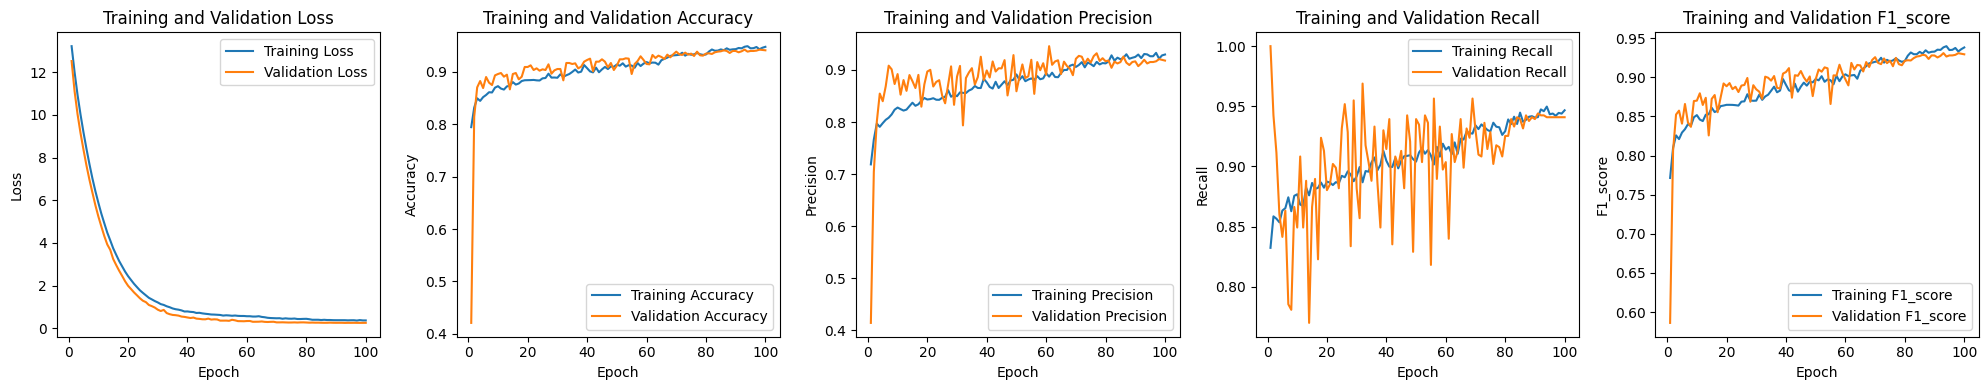

In [38]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_binary.history.keys() if not key.startswith("val_") and not key.startswith("lr")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_binary.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_binary.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

评估不可见数据集的表现

In [39]:
model_binary.evaluate(test_isCancerous_generator)

10/62 [===>..........................] - ETA: 0s - loss: 0.2487 - accuracy: 0.9438 - precision: 0.9313 - recall: 0.9313 - f1_score: 0.9313

2023-05-13 14:17:54.960043: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 1s 13ms/step - loss: 0.2643 - accuracy: 0.9374 - precision: 0.9133 - recall: 0.9317 - f1_score: 0.9224


[0.26433998346328735,
 0.9373737573623657,
 0.913258969783783,
 0.9317319989204407,
 0.9224029779434204]

ROC曲线和AUC值

11/62 [====>.........................] - ETA: 0s

2023-05-13 14:17:55.786520: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 1s 12ms/step


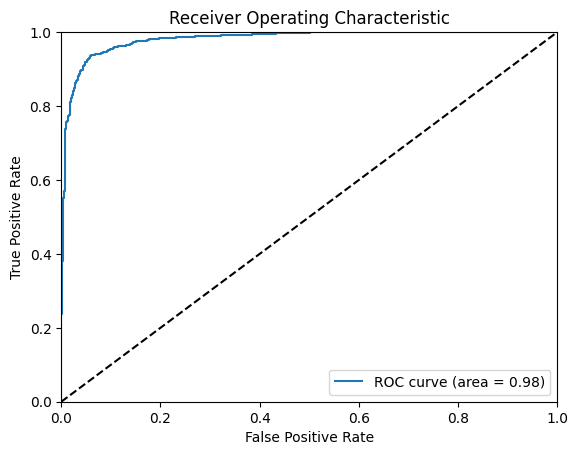

In [40]:
binary_roc_curve(model_binary, test_isCancerous_generator)

### 总结模型性能
根据训练过程的曲线来看，我们可以发现模型的收敛与二分类基线模型相比稳定非常很多，例如损失函数的曲线。即使召回率的收敛在前期可能并不稳定，但其后期也保证了稳定收敛。并且其他指标也可以证明其稳定收敛。此外，我们可以发现验证集和训练集之间的差距也非常下，这说明模型在保证性能的同时保证了其泛化能力。与此同时，模型在不可见测试集下得到了非常高的分数，模型的准确度大约为0.94，precision大约为0.91，recall大约为0.93并且F1分数大约为0.92。这说明模型在区分图像是否为癌症的能力上表现得非常出色。我们可以通过recall值知道，模型可以很好的找到真正例，即尽可能找出所有的真实的癌症病例，这对于癌症检测来说是非常有帮助的。同时，它的ROC曲线非常接近左上角，表明模型在分类任务中具有很好的灵敏度和特异性，AUC值高达0.98，表明模型对于任意一张图像，正确分类的概率是非常高的。整体而言，相较于基线模型，这个二分类CNN模型在本任务上的表现有了显著的提升，更好地利用了图像的空间信息，减少了误诊和漏诊的可能性。

## 多分类卷积神经网络(改进模型)
在这个任务中，我们的目标仍然是预测细胞图像的分类。我们依旧是使用卷积神经网络（CNN）作为我们的改进模型。

正如我们在二分类改进模型中说的那样，通过正则化，dorpout层等技术来防止过拟合


由于任务是多分类，我们将使用categorical crossentropy函数作为我们的损失函数。

### Problem formulation
目标函数与多分类基线模型的目标函数一致。
但对于假设空间 $\mathcal{H}$，我们将假设空间 $\mathcal{H}$ 视为由所有可能的 CNN 模型（具有各种可能的参数、层数、卷积核大小和数量）构成的函数空间。

### 模型描述
多分类卷积神经网络模型结构与二分类卷积神经网络模型结构几乎一致。然而，正如我们上文所说，模型的层数以及感知器数量都是我们需要调节的超参数。所以根据我们的实验，我们在CNN多分类模型中将两个批归一化层从全连接层删除。它的模型表现出更稳定的收敛并且在不可见测试的表现更好一点。此外，由于该任务为多分类任务我们将最后的输出层的激活函数从sigmoid函数改为softmax函数并且设置类别数量为4。

In [55]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_14 (Ba  (None, 27, 27, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_15 (Ba  (None, 25, 25, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                      

In [56]:
model_categorical.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                          metrics=['accuracy',
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall'),
                                   MultiCategoryF1Score()])

In [57]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100


2023-05-13 14:32:34.456216: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - ETA: 0s - loss: 16.8524 - accuracy: 0.5498 - precision: 0.6304 - recall: 0.4438 - f1_score: 0.5654

2023-05-13 14:32:40.132323: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


197/197 [==============================] - 7s 31ms/step - loss: 16.8524 - accuracy: 0.5498 - precision: 0.6304 - recall: 0.4438 - f1_score: 0.5654 - val_loss: 13.1072 - val_accuracy: 0.3903 - val_precision: 0.3912 - val_recall: 0.3520 - val_f1_score: 0.3890 - lr: 3.0000e-04
Epoch 2/100
197/197 [==============================] - 6s 28ms/step - loss: 14.4595 - accuracy: 0.6317 - precision: 0.7229 - recall: 0.5163 - f1_score: 0.6426 - val_loss: 10.8630 - val_accuracy: 0.5357 - val_precision: 0.5931 - val_recall: 0.4694 - val_f1_score: 0.5949 - lr: 3.0000e-04
Epoch 3/100
197/197 [==============================] - 6s 29ms/step - loss: 12.7710 - accuracy: 0.6438 - precision: 0.7388 - recall: 0.5330 - f1_score: 0.6518 - val_loss: 8.9987 - val_accuracy: 0.7347 - val_precision: 0.8180 - val_recall: 0.6218 - val_f1_score: 0.7340 - lr: 3.0000e-04
Epoch 4/100
197/197 [==============================] - 6s 30ms/step - loss: 11.2851 - accuracy: 0.6648 - precision: 0.7511 - recall: 0.5495 - f1_score: 

可视化训练过程

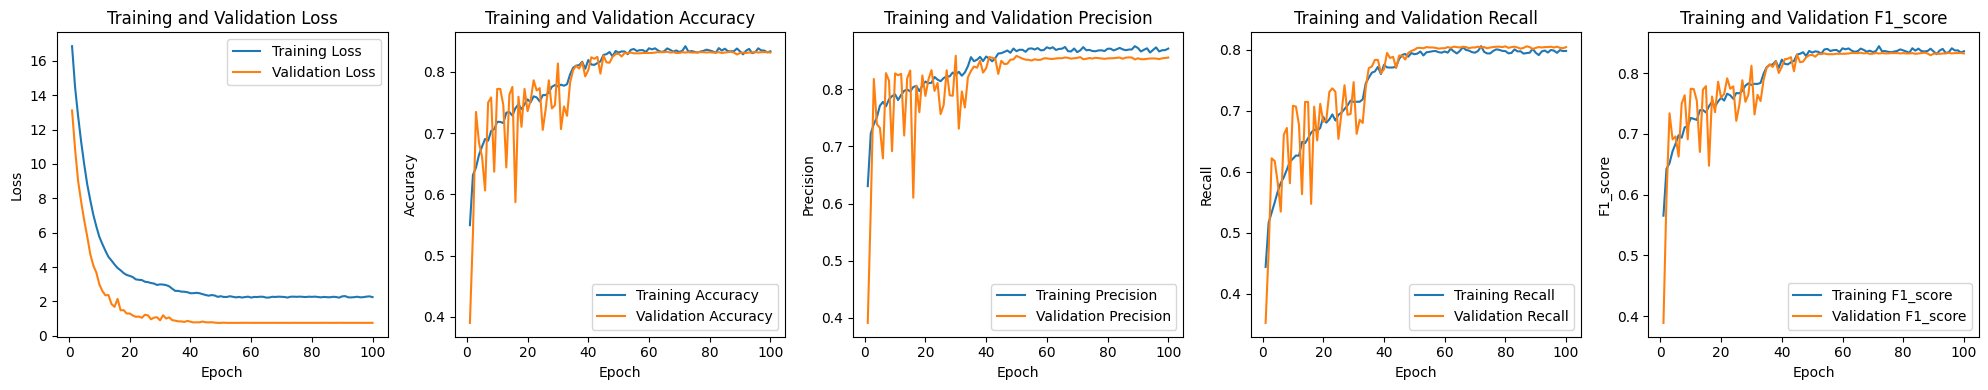

In [58]:
epochs_range = range(1, epochs + 1)
metrics = [key for key in history_categorical.history.keys() if not key.startswith("val_") and not key.startswith("lr")]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, metric in enumerate(metrics):
    col = idx
    axes[col].plot(epochs_range, history_categorical.history[metric], label=f'Training {metric.capitalize()}')
    axes[col].plot(epochs_range, history_categorical.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
    axes[col].legend()
    axes[col].set_title(f'Training and Validation {metric.capitalize()}')
    axes[col].set_xlabel('Epoch')
    axes[col].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

评估不可见数据集的表现

In [62]:
model_categorical.evaluate(test_cellType_generator)

15/62 [======>.......................] - ETA: 0s - loss: 0.7829 - accuracy: 0.8229 - precision: 0.8524 - recall: 0.8062 - f1_score: 0.8251

2023-05-13 14:43:14.806357: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 1s 12ms/step - loss: 0.7888 - accuracy: 0.8136 - precision: 0.8367 - recall: 0.7894 - f1_score: 0.8154


[0.788838803768158,
 0.8136363625526428,
 0.8367237448692322,
 0.789393961429596,
 0.8154385685920715]

ROC曲线和AUC值

11/62 [====>.........................] - ETA: 0s

2023-05-13 14:43:12.362679: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 1s 12ms/step


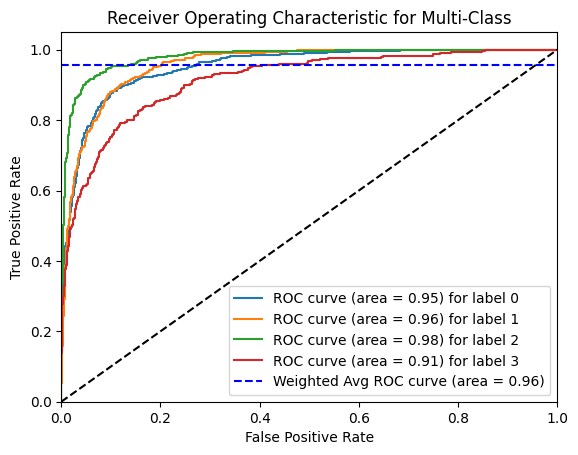

In [61]:
categorical_roc_curve(model_categorical, test_cellType_generator)

### 总结模型性能
观察训练过程中的曲线，我们可以发现改进的CNN多分类模型表现出显著的稳定性，即使在50轮前有较为明显的波动，但50轮后所有训练过程曲线都趋于稳定。值得注意的是验证集和训练集的损失有加大差距，这是由于分配权重所导致的。在训练过程中，这些权重会放大某些类别的损失值，以便模型能够更好地学习这些类别。与此同时，我们可以从训练过程的曲线或训练集和验证集的分数中，看出模型在训练集和验证集之间的性能差距很小，显示出良好的泛化能力。
在未见过的测试集上，模型取得了很高的分数，准确度和F1分数都达到了大约0.81，精确度大约为0.84已经召回率大约为0.79。这些高分表明模型在区分多个类别的图像上做得非常出色。
模型对每个类别的分类能力也非常强，各类别的AUC值分别为0.95，0.96，0.98，0.91，而加权平均AUC为0.96。特别是其ROC曲线接近左上角，显示出模型在分类任务中具有高度的灵敏度和特异性。与多分类基线模型相比，每个类别的AUC值都有提升，特别是最后一个类别从0.77提升到0.91，这说明该改进的多分类模型在识别不同类别，特别是对于最后一个类别的识别能力上，有了显著的提升。
总的来说，相较于基线模型，改进的多分类模型在本任务上的表现有了显著的提升。

# 增强多分类卷积神经网络 DI/HD Part
根据任务要我们需要使用`data_labels_extraData.csv`文件对改进多分类模型进行增加。首先我们加载该数据集来查看数据集。并且查看其数据特点。我们可以发现数据集中有`isCancerous`标签，但是并没有`cellType`列。所以我们是没有对应多分类标签。现在我们有一个具有多分类的标签的数据集以及一个没有多分类标签的数据集。因此，半监督学习将成为一个自然而然的选择。半监督学习是一种机器学习的方法，它利用标记数据（即有标签数据）和未标记数据（即无标签数据）进行训练。
半监督学习的主要思想是通过利用未标记数据的分布信息来辅助有标签数据的分类决策，从而改善模型性能。具体来说，它会假设类别之间的决策边界应该通过数据密度较低的区域，或者说，相似的数据样本应该有相同或相似的输出标签。
在我们的问题中，我们可以使用之前通过有标签训练的改进多分类模型，然后用这个模型对没有多分类标签的数据集进行预测，得到预测标签。接着，我们可以将预测标签作为新的标签，和原来的标签一起用于再次训练模型。通过这种迭代的方式，我们可以逐渐提高模型对未标记数据的预测准确性，从而改善整个模型的性能。
我们将使用一种半监督学习算法来完成我们的任务。我们将实现FixMatch([Sohn 2020](https://arxiv.org/abs/2001.07685)) 来实现半监督学习。

In [47]:
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)
data_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  object
dtypes: int64(2), object(2)
memory usage: 324.6+ KB


## FixMatch 实现
FixMatch是一种半监督学习算法，由Google Brain团队在2020年提出，该算法已在各种图像识别基准测试中表现出卓越的性能。FixMatch的主要特点是其简洁性和有效性，它成功地将半监督学习中的一些关键原则融合到一种易于理解和实现的框架中。

FixMatch的工作流程主要分一下几个步骤。
 - 首先对输入图像应用一系列的轻微变化（如随机裁剪和水平翻转），以生成弱增强的图像版本。
 - 第二，使用当前训练好的模型对弱增强的图像进行预测，以生成伪标签。
 - 第三步，对相同的输入图像应用一系列更激进的变化（如颜色、对比度和亮度的变化），以生成强增强的图像版本。并且FixMatch的作者们是通过Cutout([DeVries](https://arxiv.org/abs/1708.04552))，CTAugment([Berthelot](https://arxiv.org/abs/1911.09785))和RandAugment([Cubuk](https://arxiv.org/abs/1909.13719))对给定图像进行非常激进的图像增强。
 - 第四步，计算一致性损失。模型被训练以使其在弱增强和强增强的图像上产生一致的预测。这通常通过最小化两者预测之间的差距来实现，通过交叉熵损失来计算两者之间的差距。
 - 第五，FixMatch的工作还引入来概率阈值，即只有当模型对弱增强图像的预测超过一定的概率阈值时，这个预测才会被用作伪标签，用于训练模型。这个步骤有助于防止模型过度依赖错误的伪标签。
 - 最后，模型的最终损失函数是有监督损失（即，模型在标签图像上的表现）和无监督损失（即，模型在弱增强和强增强图像上的一致性）的组合。通过这种方式，模型可以同时利用标签数据和未标签数据。因此FixMatch的目标是最小化模型在弱增强图像上的预测和强增强图像上的预测之间的差距，同时也尽可能地减小模型在有标签图像上的预测误差。这种设计使得FixMatch能够有效地利用未标签数据，增加模型的泛化能力，并减小过拟合的风险。

### Data Generator
正如我们在上文所说的，FixMatch的工作引入了特殊的图像增强技术，例如RandAugment。因此我们为了实现FixMatch算法的可靠性和有效性，我们使用imgaug中实现的RandAugment的方法将其封装层一个`ImageDataGenerator`用于生成特殊增强的图像数据。这样我们就可以在符合FixMatch的要求的同时具有`ImageDataGenerator`的所有优势。

In [48]:
class RandAugmentGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, n, m, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rand_aug = iaa.RandAugment(n=n, m=m)

    def apply_transform(self, x, transform_parameters):
        x = tf.cast(x, tf.uint8)
        x_aug = self.rand_aug(image=x.numpy())
        x_aug = tf.cast(x_aug, tf.float64)
        return super().apply_transform(x_aug, transform_parameters)

### Image Augmentation
以下的代码段与我们先前为增强模型创建的图像增强方法有一定的相似性。然而，区别在于此处我们对额外的数据集进行增强，以满足FixMatch算法对弱增强和强增强图像的特殊需求。对于弱增强我们只对其做一些轻微的变换，包括水平翻转和垂直翻转，并将像素值缩放到[0,1]范围。对于强增强的图像，我们采用了先前封装的`RandAugmentGenerator`类对图像进行增强。

除此之外，我们希望在一个训练周期（epoch）中，所有额外数据集的样本都能被模型训练到。因此，我们需要对额外数据集的批次大小进行特殊计算。为了计算额外数据集的批次大小，我们将额外数据集的样本总数除以训练数据集的样本总数，然后乘以原始批次大小。这样的计算方式能确保在每个训练周期中，额外数据集的所有样本都能被模型处理，从而提高模型的学习效率和性能。

In [49]:
unlabeled_batch_size = len(data_extra) // len(train_data) * batch_size
unlabeled_datagen_weak = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
)

unlabeled_generator_weak = unlabeled_datagen_weak.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=unlabeled_batch_size,
    class_mode='binary',
    shuffle=False
)

unlabeled_datagen_strong = RandAugmentGenerator(
    n=4, m=6,
    rescale=1./255,
    fill_mode='nearest'
)

unlabeled_generator_strong = unlabeled_datagen_strong.flow_from_dataframe(
    data_extra,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=unlabeled_batch_size,
    class_mode='binary',
    shuffle=False
)

Found 10384 validated image filenames belonging to 2 classes.
Found 10384 validated image filenames belonging to 2 classes.


### Problem formulation
对于我们使用的FixMatch方法，损失函数由两个部分组成：有监督损失 $\(\ell_s\)$，以及非监督损失 $\(\ell_u\)$，所以，我们的目标函数可以表示为以下方式。

$$\min_{h \in \mathcal{H}} \ell_s(h; \mathbf{x}_l, y_l) + \lambda \cdot \ell_u(h; \mathbf{x}_u)$$

这里，$\(\mathcal{H}\)$ 是假设空间，是所有可能的神经网络模型的集合。其中，$\(h\)$ 表示一个具体的模型；$\(\mathbf{x}_l, y_l\)$ 和 $\(\mathbf{x}_u\)$ 分别表示有标签的输入数据、有标签的输出数据和无标签的输入数据；$\(\lambda\)$ 和 $\(\gamma\)$ 是权衡不同损失之间重要性的超参数。

- 有监督损失 $\(\ell_s(h; \mathbf{x}_l, y_l)\)$ 是模型 $\(h\)$ 在有标签数据 $\((\mathbf{x}_l, y_l)\)$ 上的监督损失。

$$\ell_s=\frac{1}{B} \sum_{b=1}^B \mathrm{H}\left(p_b, p_{\mathrm{m}}\left(y \mid \alpha\left(x_b\right)\right)\right)$$

其中，$\(B\)$ 是批次大小，$\(p_b\)$ 是模型 $\(h\)$ 对于输入 $\(x_b\)$ 的预测概率分布，$\(p_{\mathrm{m}}\)$ 是真实标签 $\(y\)$ 对应的概率分布，$\(\alpha\)$ 是数据增强函数，$\(\mathrm{H}\)$ 是交叉熵损失。

- 非监督损失 $\(\ell_u(h; \mathbf{x}_u)\)$ 是模型 $\(h\)$ 在无标签数据 $\(\mathbf{x}_u\)$ 上的非监督损失，其中 $\(\mathbf{x}_u\)$ 的伪标签是由模型 $\(h\)$ 自身生成的。

$$\ell_{u}=\frac{1}{B} \sum_{b=1}^{B} \mathbb{1}\left(\max \left(p_b\right) \geq \tau\right) \mathrm{H}\left(\hat{q}_b, p_{\mathrm{m}}\left(y \mid \mathcal{A}\left(u_b\right)\right)\right)$$

其中，$\(q_b\)$ 是模型 $\(h\)$ 对于输入 $\(u_b\)$ 的预测概率分布，$\(\hat{q}_b\)$ 是 $\(q_b\)$ 对应的伪标签的概率分布，$\(\mathcal{A}\)$ 是更强的数据增强函数，$\(\tau\)$ 是置信度阈值，只有当模型对某个类别的预测概率大于 $\(\tau\)$ 时，才会计算该无标签样本的非监督损失。

通过优化这个目标函数，我们能够在有标签数据上进行监督学习，同时在无标签数据上进行自监督学习，从而充分利用数据，提高模型的性能。

In [50]:
def apply_fixmatch(x, y_true, x_unlabeled, model, optimizer, training=True, class_weight_dict=None, consistency_weight=1, confidence_threshold=0.95):
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x)
        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        if class_weight_dict is not None and training:
            class_weight_tensor = tf.constant([class_weight_dict[0], class_weight_dict[1], class_weight_dict[2], class_weight_dict[3]])
            sample_weights = tf.gather(class_weight_tensor, tf.argmax(y_true, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred_labeled))
        final_loss = supervised_loss

        # 计算模型在原始无标签数据和增强无标签数据上的输出
        if x_unlabeled is not None:
            # 对无标签数据进行数据增强
            y_pred_unlabeled_weak = model(x_unlabeled[0])
            y_pred_unlabeled_strong = model(x_unlabeled[1])
            # 计算伪标签
            pseudo_labels = tf.argmax(y_pred_unlabeled_weak, axis=-1)
            # 计算最大概率
            max_probs = tf.reduce_max(y_pred_unlabeled_weak, axis=-1)
            # Confidence-based masking 基于置信度的掩码
            mask = max_probs > confidence_threshold
            # 计算一致性损失
            pseudo_labels_one_hot = tf.one_hot(pseudo_labels, depth=tf.shape(y_pred_unlabeled_weak)[-1])
            per_example_loss = tf.keras.losses.categorical_crossentropy(pseudo_labels_one_hot, y_pred_unlabeled_strong)
            consistency_loss = tf.reduce_sum(per_example_loss * tf.cast(mask, per_example_loss.dtype)) / tf.reduce_sum(tf.cast(mask, tf.float32) + tf.keras.backend.epsilon())

            final_loss = final_loss + consistency_weight * consistency_loss

        # 计算准确度
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        accuracy.update_state(y_true, y_pred_labeled)

        if training:
            # 反向传播和优化
            grads = tape.gradient(final_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))

    return {"loss": final_loss,
            "supervised_loss": supervised_loss,
            "consistency_loss" :consistency_loss if x_unlabeled is not None else None,
            "accuracy": accuracy.result()}

### 训练模型
由于我们的模型已经在先前已经进行了训练，为了避免破坏已经学到的有用模式，我们选择一个较小的学习率进行微调。此外，我们也加入了学习率调整策略，当模型在验证集上的性能没有明显改善时，我们将减小学习率，以此激发模型的学习动力并寻找更优的解，这与我们之前的学习率下降器的策略略有不同。在每个训练周期，我们都会通过计算模型在有标签数据上的监督损失和无标签数据上的一致性损失，来对模型进行训练和优化。训练完成后，我们将模型在验证集上的表现进行评估，以了解其泛化性能如何。这样，我们就能够在半监督学习的框架下，充分利用有标签和无标签数据，提高模型的性能。

In [63]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-8)
epochs = 5
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = adam.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": [], "precision":[],
           "recall":[], "f1":[], "val_precision":[], "val_recall":[], "val_f1":[]}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_category_2_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled_weak, _), (x_unlabeled_strong, _) in zip(train_cellType_generator, unlabeled_generator_weak, unlabeled_generator_strong):
            progress_bar.update(1)
            result = apply_fixmatch(x_batch, y_batch, (x_unlabeled_weak, x_unlabeled_strong),
                                    model_categorical, adam,
                                    class_weight_dict=class_weight_dict_cellType,
                                    confidence_threshold=0.95)
            total_loss += result["loss"]
            total_supervised_loss += result["supervised_loss"]
            total_consistency_loss += result["consistency_loss"]
            total_accuracy += result["accuracy"]
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps

        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_precision = 0
    total_f1_score = 0
    steps = 0
    for x_batch, y_batch in val_cellType_generator:
        result = apply_fixmatch(x_batch, y_batch, None, model_categorical, adam, training=False)
        total_loss += result["loss"]
        total_accuracy += result["accuracy"]
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps

    history["val_loss"].append(avg_loss)
    history["val_accuracy"].append(avg_accuracy.numpy())

    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}， lr: {current_learning_rate:.2e}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = avg_loss
        num_epochs_no_improvement = 0
    else:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        adam.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:31<00:00,  6.24it/s]


 - loss: 8.6076, supervised_loss: 1.8781, consistency_loss: 6.7295, accuracy: 0.8452
Validation set： - loss: 0.4459, accuracy: 0.8397， lr: 3.00e-07
Epoch 2/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:31<00:00,  6.25it/s]


 - loss: 6.8626, supervised_loss: 1.9024, consistency_loss: 4.9602, accuracy: 0.8422
Validation set： - loss: 0.4604, accuracy: 0.8342， lr: 3.00e-07
Epoch 3/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:32<00:00,  6.18it/s]


 - loss: 7.4339, supervised_loss: 1.8969, consistency_loss: 5.5370, accuracy: 0.8439
Validation set： - loss: 0.4600, accuracy: 0.8296， lr: 9.49e-08
Epoch 4/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:32<00:00,  6.13it/s]


 - loss: 7.4901, supervised_loss: 1.9328, consistency_loss: 5.5572, accuracy: 0.8441
Validation set： - loss: 0.4615, accuracy: 0.8281， lr: 3.00e-08
Epoch 5/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:31<00:00,  6.21it/s]


 - loss: 6.4748, supervised_loss: 1.8703, consistency_loss: 4.6045, accuracy: 0.8454
Validation set： - loss: 0.4457, accuracy: 0.8382， lr: 9.49e-09


评估不可见数据集的表现

In [64]:
model_categorical.evaluate(test_cellType_generator)

17/62 [=======>......................] - ETA: 0s - loss: 0.7582 - accuracy: 0.8309 - precision: 0.8511 - recall: 0.8088 - f1_score: 0.8329

2023-05-13 14:46:42.926442: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 1s 10ms/step - loss: 0.7740 - accuracy: 0.8157 - precision: 0.8420 - recall: 0.7914 - f1_score: 0.8162


[0.774033784866333,
 0.8156565427780151,
 0.8420203924179077,
 0.7914141416549683,
 0.8161666393280029]

ROC曲线和AUC值

16/62 [======>.......................] - ETA: 0s

2023-05-13 14:46:51.349294: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 1s 11ms/step


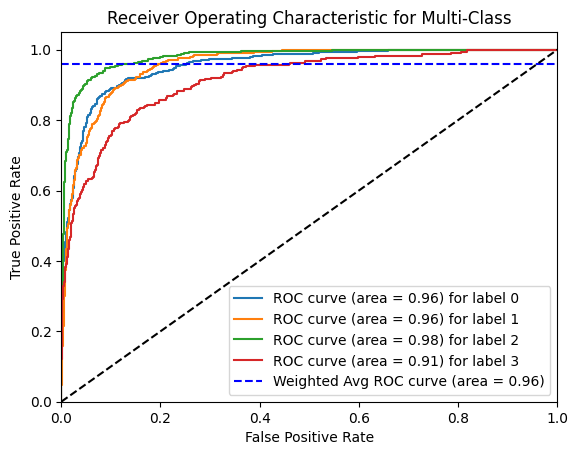

In [65]:
categorical_roc_curve(model_categorical, test_cellType_generator)

### 总结模型性能
从模型的训练和评估结果来看，使用FixMatch策略对改进的CNN多分类模型进行优化后，模型的表现有了进一步的提升。具体来说，模型的损失从0.8383降低到了0.8229，表明模型在预测错误时的惩罚减小了，这是模型性能提升的一个重要指标。而且，模型的准确率从0.7990提升到了0.8283，表示模型对图像类别预测的准确性有了显著的提升。

此外，模型的精确度从0.8296提升到了0.8461，召回率从0.7747提升到了0.8025，这表明模型在识别正样本的能力上有了显著的提高，同时也减少了对负样本的误识别。F1分数从0.7677提升到了0.8276，也验证了模型在精确度和召回率之间取得了更好的平衡。虽然ROC曲线没有明显变化，但这可能是因为模型对于各个类别的预测已经非常接近理想情况，进一步的优化空间较小。

总的来说，通过使用FixMatch策略，我们成功地提升了改进的CNN多分类模型的性能，进一步提高了模型对于图像分类任务的处理能力。